In [3]:
!pip install wfdb protobuf==3.20.3 --quiet

import os
import numpy as np
import pandas as pd

import wfdb
from scipy import signal
from scipy.fft import rfft
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptograp

In [2]:
import os

base_path = "/kaggle/input/dl-dataset"
print(os.listdir(base_path))


['ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3']


In [5]:
import os

BASE_PATH = "/kaggle/input/dl-dataset"
ROOT = os.path.join(BASE_PATH, "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3")

print("Inside BASE_PATH:", os.listdir(BASE_PATH))
print("\nInside ROOT:", os.listdir(ROOT))

DATA_DIR = ROOT   # <--- FIXED
print("\nInside DATA_DIR:", os.listdir(DATA_DIR))

RECORDS100 = os.path.join(DATA_DIR, "records100")
print("\nFirst few folders in records100:", os.listdir(RECORDS100)[:5])

SAMPLE_REC_00000 = os.path.join(RECORDS100, "00000")
print("\nFiles in records100/00000:", os.listdir(SAMPLE_REC_00000))



Inside BASE_PATH: ['ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3']

Inside ROOT: ['records500', 'SHA256SUMS.txt', 'RECORDS', 'example_physionet.py', 'ptbxl_v103_changelog.txt', 'scp_statements.csv', 'ptbxl_database.csv', 'LICENSE.txt', 'ptbxl_v102_changelog.txt', 'records100']

Inside DATA_DIR: ['records500', 'SHA256SUMS.txt', 'RECORDS', 'example_physionet.py', 'ptbxl_v103_changelog.txt', 'scp_statements.csv', 'ptbxl_database.csv', 'LICENSE.txt', 'ptbxl_v102_changelog.txt', 'records100']

First few folders in records100: ['21000', '15000', '18000', '14000', '19000']

Files in records100/00000: ['00775_lr.dat', '00103_lr.dat', '00989_lr.hea', '00452_lr.dat', '00940_lr.hea', '00054_lr.hea', '00707_lr.hea', '00988_lr.dat', '00875_lr.hea', '00429_lr.dat', '00821_lr.hea', '00313_lr.dat', '00039_lr.hea', '00555_lr.dat', '00556_lr.hea', '00203_lr.hea', '00698_lr.dat', '00315_lr.hea', '00179_lr.hea', '00967_lr.hea', '00159_lr.hea', '00318_lr.hea', '00297_lr.hea', '00723_

In [6]:
import pandas as pd
import os

DATA_DIR = "/kaggle/input/dl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

meta = pd.read_csv(os.path.join(DATA_DIR, "ptbxl_database.csv"))
scp_df = pd.read_csv(os.path.join(DATA_DIR, "scp_statements.csv"), index_col=0)

print("meta shape:", meta.shape)
print("scp_df shape:", scp_df.shape)


meta shape: (21799, 28)
scp_df shape: (71, 12)


In [17]:
scp_df = scp_df[scp_df['diagnostic'] == 1]

SUPERCLASS_MAP = {
    'NORM': 0,
    'MI': 1,
    'STTC': 2,
    'HYP': 3,
    'CD': 4
}

def get_superclass(code):
    try:
        diag = scp_df.loc[code, 'diagnostic_class']
        return SUPERCLASS_MAP.get(diag, None)
    except:
        return None

def extract_label(row):
    s = row['scp_codes']
    try:
        d = eval(s)
    except:
        return None
    labels = []
    for k in d.keys():
        cls = get_superclass(k)
        if cls is not None:
            labels.append(cls)
    if len(labels)==0:
        return None
    return labels[0]   


In [18]:
TARGET_FS = 250
WINDOW_SEC = 5
WINDOW_SAMPLES = TARGET_FS * WINDOW_SEC
OVERLAP = 0.5

def resample(sig, orig_fs):
    if orig_fs == TARGET_FS:
        return sig
    new_len = int(len(sig) * TARGET_FS / orig_fs)
    return signal.resample(sig, new_len)

def highpass(sig):
    b,a = signal.butter(2, 0.5/(TARGET_FS/2), 'high')
    return signal.filtfilt(b,a,sig)

def bandpass(sig):
    b,a = signal.butter(4, [0.5/(TARGET_FS/2), 40/(TARGET_FS/2)], 'band')
    return signal.filtfilt(b,a,sig)

def notch(sig, f0=50):
    w0 = f0/(TARGET_FS/2)
    b,a = signal.iirnotch(w0, 30)
    return signal.filtfilt(b,a,sig)

def normalize(sig):
    return (sig - np.mean(sig)) / (np.std(sig) + 1e-8)


In [19]:
def extract_windows_fft(row):
    file_path = os.path.join(DATA_DIR, row['filename_hr'])
    file_path = file_path.replace(".dat", "")

    try:
        rec = wfdb.rdrecord(file_path)
    except:
        return None, None


    sig = rec.p_signal          # shape: (T, 12)
    fs = rec.fs

    # 1) Resample
    if fs != TARGET_FS:
        sig = np.array([resample(sig[:,i], fs) for i in range(sig.shape[1])]).T

    # 2) Filters
    for i in range(12):
        sig[:, i] = highpass(sig[:, i])
        sig[:, i] = bandpass(sig[:, i])
        sig[:, i] = notch(sig[:, i])
        sig[:, i] = normalize(sig[:, i])

    # 3) Windowing
    hop = int(WINDOW_SAMPLES*(1-OVERLAP))
    windows = []
    for start in range(0, len(sig)-WINDOW_SAMPLES, hop):
        w = sig[start:start+WINDOW_SAMPLES]        # shape: (1250, 12)

        # 4) FFT for each lead (base paper)
        fft_win = []
        for lead in range(12):
            f = np.abs(rfft(w[:, lead]))[:600]     # keep first 600 freq bins
            fft_win.append(f)

        fft_win = np.array(fft_win).T              # shape: (600, 12)
        windows.append(fft_win.astype(np.float32))

    return windows, extract_label(row)


In [20]:
X, Y = [], []

for i, row in meta.iterrows():
    label = extract_label(row)
    if label is None:
        continue

    win, lab = extract_windows_fft(row)
    if win is None:
        continue

    for w in win:
        X.append(w)
        Y.append(lab)

X = np.array(X)
Y = np.array(Y)

print("Final dataset shape:", X.shape, Y.shape)
print("Class distribution:", Counter(Y)) 


Final dataset shape: (42776, 600, 12) (42776,)
Class distribution: Counter({0: 19028, 1: 10848, 2: 5634, 4: 4650, 3: 2616})


In [21]:
from sklearn.utils import resample
import numpy as np

def balance_dataset(X, Y):
    X_bal = []
    Y_bal = []
    classes = np.unique(Y)

    # find max count
    max_count = max([np.sum(Y == c) for c in classes])

    for c in classes:
        X_cls = X[Y == c]
        Y_cls = Y[Y == c]

        # oversample minority classes
        X_res, Y_res = resample(
            X_cls, Y_cls,
            replace=True,
            n_samples=max_count,
            random_state=42
        )

        X_bal.append(X_res)
        Y_bal.append(Y_res)

    Xb = np.concatenate(X_bal)
    Yb = np.concatenate(Y_bal)

    # shuffle
    idx = np.random.permutation(len(Yb))
    return Xb[idx], Yb[idx]

# APPLY HERE
X, Y = balance_dataset(X, Y)

print("Balanced shape:", X.shape)
print("Balanced class distribution:", Counter(Y))


Balanced shape: (95140, 600, 12)
Balanced class distribution: Counter({0: 19028, 2: 19028, 1: 19028, 4: 19028, 3: 19028})


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

In [23]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])

        ce = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred)
        pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        fl = (1 - pt) ** gamma

        return alpha * fl * ce

    return loss


In [24]:
from tensorflow.keras import layers, models

def build_cnn_lstm(input_shape=(600, 12), num_classes=5):

    inp = layers.Input(shape=input_shape)

    x = layers.Conv1D(32, 7, activation='relu', padding='same')(inp)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)

    x = layers.LSTM(200, return_sequences=False)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out)

    return model


In [25]:
model = build_cnn_lstm()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.25),   # ← FOCAL LOSS HERE
    metrics=["accuracy"]
)

model.summary()


I0000 00:00:1763892537.895955      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763892537.896588      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 600, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 600, 32)        │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 600, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 600, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 600, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 600, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       365,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,357 (2.15 MB)

 Trainable params: 564,357 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5
)
history = model.fit(
    X_train, y_train,
    steps_per_epoch=600,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early, reduceLR],
    verbose=1
)

Epoch 1/30


I0000 00:00:1763892565.752271     145 cuda_dnn.cc:529] Loaded cuDNN version 90300


600/600 ━━━━━━━━━━━━━━━━━━━━ 90s 140ms/step - accuracy: 0.2403 - loss: 0.2531 - val_accuracy: 0.2992 - val_loss: 0.2367 - learning_rate: 1.0000e-04
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 91s 151ms/step - accuracy: 0.3106 - loss: 0.2347 - val_accuracy: 0.3238 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 90s 150ms/step - accuracy: 0.3241 - loss: 0.2293 - val_accuracy: 0.3415 - val_loss: 0.2242 - learning_rate: 1.0000e-04
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 90s 150ms/step - accuracy: 0.3334 - loss: 0.2249 - val_accuracy: 0.3478 - val_loss: 0.2232 - learning_rate: 1.0000e-04
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 90s 150ms/step - accuracy: 0.3427 - loss: 0.2229 - val_accuracy: 0.3536 - val_loss: 0.2208 - learning_rate: 1.0000e-04
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 90s 150ms/step - accuracy: 0.3526 - loss: 0.2197 - val_accuracy: 0.3559 - val_loss: 0.2175 - learning_rate: 1.0000e-04
Epoch 7/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 90s 149ms/step - 

In [27]:
early = tf.keras.callbacks.EarlyStopping(
    patience=8,                  # increased patience
    restore_best_weights=True
)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.3,                  # stronger LR reduction
    patience=4,                  # wait 4 epochs before reducing LR
    min_lr=1e-7,                 # don't reduce below this
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,                   # more epochs for better learning
    batch_size=128,              # faster + smoother gradients
    shuffle=True,
    callbacks=[early, reduceLR],
    verbose=1
)



Epoch 1/60
595/595 ━━━━━━━━━━━━━━━━━━━━ 88s 147ms/step - accuracy: 0.5378 - loss: 0.1373 - val_accuracy: 0.5193 - val_loss: 0.1490 - learning_rate: 1.0000e-04
Epoch 2/60
595/595 ━━━━━━━━━━━━━━━━━━━━ 86s 144ms/step - accuracy: 0.5540 - loss: 0.1324 - val_accuracy: 0.5272 - val_loss: 0.1470 - learning_rate: 1.0000e-04
Epoch 3/60
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.5531 - loss: 0.1310 - val_accuracy: 0.5299 - val_loss: 0.1439 - learning_rate: 1.0000e-04
Epoch 4/60
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.5570 - loss: 0.1284 - val_accuracy: 0.5305 - val_loss: 0.1427 - learning_rate: 1.0000e-04
Epoch 5/60
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.5572 - loss: 0.1283 - val_accuracy: 0.5327 - val_loss: 0.1417 - learning_rate: 1.0000e-04
Epoch 6/60
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.5624 - loss: 0.1246 - val_accuracy: 0.5369 - val_loss: 0.1411 - learning_rate: 1.0000e-04
Epoch 7/60
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 14

In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,                 # more patience for long training
    restore_best_weights=True
)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,                  # strong LR drop
    patience=5,                  # wait 5 epochs
    min_lr=1e-7,                 # don't reduce below this
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,                  # continue to 100 total
    batch_size=128,
    shuffle=True,
    callbacks=[early, reduceLR, checkpoint],
    verbose=1
)


Epoch 1/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7697 - loss: 0.0463
Epoch 1: val_loss improved from inf to 0.09130, saving model to best_model.h5


595/595 ━━━━━━━━━━━━━━━━━━━━ 88s 147ms/step - accuracy: 0.7697 - loss: 0.0463 - val_accuracy: 0.7251 - val_loss: 0.0913 - learning_rate: 2.7000e-06
Epoch 2/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7720 - loss: 0.0455
Epoch 2: val_loss did not improve from 0.09130
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.7720 - loss: 0.0455 - val_accuracy: 0.7248 - val_loss: 0.0917 - learning_rate: 2.7000e-06
Epoch 3/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7736 - loss: 0.0454
Epoch 3: val_loss did not improve from 0.09130
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.7736 - loss: 0.0454 - val_accuracy: 0.7253 - val_loss: 0.0920 - learning_rate: 2.7000e-06
Epoch 4/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7756 - loss: 0.0451
Epoch 4: val_loss did not improve from 0.09130
595/595 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.7756 - loss: 0.0451 - val_accuracy: 0.7280 - val_loss: 0.0920 - learning_rate: 2.7000e-06


In [29]:
pred = np.argmax(model.predict(X_val), axis=1)

print(classification_report(y_val, pred))
print(confusion_matrix(y_val, pred))


595/595 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step
              precision    recall  f1-score   support

           0       0.67      0.47      0.55      3806
           1       0.67      0.40      0.50      3805
           2       0.63      0.83      0.71      3806
           3       0.91      0.99      0.95      3806
           4       0.73      0.93      0.82      3805

    accuracy                           0.73     19028
   macro avg       0.72      0.73      0.71     19028
weighted avg       0.72      0.73      0.71     19028

[[1800  431  990  281  304]
 [ 419 1508  866   55  957]
 [ 371  193 3156   23   63]
 [  15    4    0 3782    5]
 [  95  110   33   15 3552]]


In [31]:
###########################################################
#  HYBRID PTB-XL PIPELINE (TIME-DOMAIN + FFT)
#  FULLY CORRECTED — SINGLE RUNNABLE CELL FOR KAGGLE
###########################################################

import os
import numpy as np
import wfdb
from scipy import signal
from scipy.fft import rfft
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

print("Starting Hybrid PTB-XL Pipeline...")

###########################################################
# 1. CONFIG
###########################################################

DATA_DIR = "/kaggle/input/dl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

TARGET_FS = 250
WINDOW_SEC = 5
WINDOW_SAMPLES = TARGET_FS * WINDOW_SEC
OVERLAP = 0.5


###########################################################
# 2. FILTERS + PREPROCESSING
###########################################################

def resample(sig, orig_fs):
    if orig_fs == TARGET_FS:
        return sig
    new_len = int(len(sig) * TARGET_FS / orig_fs)
    return signal.resample(sig, new_len)

def highpass(sig):
    b,a = signal.butter(2, 0.5/(TARGET_FS/2), 'high')
    return signal.filtfilt(b,a,sig)

def bandpass(sig):
    b,a = signal.butter(4, [0.5/(TARGET_FS/2), 40/(TARGET_FS/2)], 'band')
    return signal.filtfilt(b,a,sig)

def notch(sig, f0=50):
    w0 = f0/(TARGET_FS/2)
    b,a = signal.iirnotch(w0, 30)
    return signal.filtfilt(b,a,sig)

def normalize(sig):
    return (sig - np.mean(sig)) / (np.std(sig) + 1e-8)


###########################################################
# 3. LABEL EXTRACTION
###########################################################

import pandas as pd

meta = pd.read_csv(os.path.join(DATA_DIR, "ptbxl_database.csv"))
scp_df = pd.read_csv(os.path.join(DATA_DIR, "scp_statements.csv"), index_col=0)

scp_df = scp_df[scp_df['diagnostic'] == 1]

SUPERCLASS_MAP = {
    'NORM': 0,
    'MI':   1,
    'STTC': 2,
    'HYP':  3,
    'CD':   4
}

def get_superclass(code):
    try:
        diag = scp_df.loc[code, 'diagnostic_class']
        return SUPERCLASS_MAP.get(diag, None)
    except:
        return None

def extract_label(row):
    try:
        d = eval(row['scp_codes'])
    except:
        return None
    labels = []
    for k in d.keys():
        cls = get_superclass(k)
        if cls is not None:
            labels.append(cls)
    return labels[0] if len(labels) else None


###########################################################
# 4. HYBRID WINDOW EXTRACTOR (RAW + FFT)
###########################################################

def extract_windows_hybrid(row):

    file_path = os.path.join(DATA_DIR, row['filename_hr']).replace(".dat", "")

    try:
        rec = wfdb.rdrecord(file_path)
    except:
        return None, None, None

    sig = rec.p_signal          # (T, 12)
    fs = rec.fs

    if fs != TARGET_FS:
        sig = np.array([resample(sig[:,i], fs) for i in range(sig.shape[1])]).T

    for i in range(12):
        sig[:, i] = highpass(sig[:, i])
        sig[:, i] = bandpass(sig[:, i])
        sig[:, i] = notch(sig[:, i])
        sig[:, i] = normalize(sig[:, i])

    hop = int(WINDOW_SAMPLES*(1-OVERLAP))
    raw_windows, fft_windows = [], []

    for start in range(0, len(sig)-WINDOW_SAMPLES, hop):

        w = sig[start:start+WINDOW_SAMPLES]           # (1250,12)
        raw_windows.append(w.astype(np.float32))

        fft_win = []
        for lead in range(12):
            f = np.abs(rfft(w[:, lead]))[:600]
            fft_win.append(f)
        fft_win = np.array(fft_win).T                 # (600,12)
        fft_windows.append(fft_win.astype(np.float32))

    return raw_windows, fft_windows, extract_label(row)


###########################################################
# 5. BUILD FULL DATASET
###########################################################

X_time = []
X_fft = []
Y = []

print("Extracting windows...")
for _, row in meta.iterrows():

    raw_wins, fft_wins, lab = extract_windows_hybrid(row)
    if raw_wins is None or lab is None:
        continue

    for r, f in zip(raw_wins, fft_wins):
        X_time.append(r)
        X_fft.append(f)
        Y.append(lab)

X_time = np.array(X_time)
X_fft = np.array(X_fft)
Y = np.array(Y)

print("Shapes:")
print("X_time:", X_time.shape)
print("X_fft:", X_fft.shape)
print("Y:", Y.shape)


###########################################################
# 6. SPLIT TRAIN / VAL
###########################################################

X_time_train, X_time_val, X_fft_train, X_fft_val, y_train, y_val = train_test_split(
    X_time, X_fft, Y, test_size=0.2, stratify=Y, random_state=42
)


###########################################################
# 7. FOCAL LOSS
###########################################################

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=5)
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce)
        focal = alpha * (1 - pt) ** gamma * ce
        return tf.reduce_mean(focal)
    return loss


###########################################################
# 8. HYBRID MODEL (CNN + BiLSTM + FFT)
###########################################################

# TIME BRANCH
inp_time = layers.Input(shape=(1250,12))
x = layers.Conv1D(64,7,padding='same',activation='relu')(inp_time)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(128,5,padding='same',activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(256,5,padding='same',activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# FFT BRANCH
inp_fft = layers.Input(shape=(600,12))
y = layers.Conv1D(64,7,padding='same',activation='relu')(inp_fft)
y = layers.MaxPooling1D(2)(y)
y = layers.Conv1D(128,5,padding='same',activation='relu')(y)
y = layers.MaxPooling1D(2)(y)
y = layers.Flatten()(y)
y = layers.Dense(256, activation='relu')(y)
y = layers.Dropout(0.3)(y)

# MERGE
combined = layers.concatenate([x, y])
z = layers.BatchNormalization()(combined)
z = layers.Dense(256, activation='relu')(z)
z = layers.Dropout(0.3)(z)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.2)(z)
out = layers.Dense(5, activation='softmax')(z)

model = models.Model([inp_time, inp_fft], out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_loss(),
    metrics=['accuracy']
)

model.summary()


###########################################################
# 9. CLASS WEIGHTS
###########################################################

cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y),
    y=Y
)
cw = dict(enumerate(cw))


###########################################################
# 10. TRAIN MODEL
###########################################################

checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

early = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

reduceLR = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    [X_time_train, X_fft_train], y_train,
    validation_data=([X_time_val, X_fft_val], y_val),
    epochs=100,
    batch_size=128,
    callbacks=[checkpoint, early, reduceLR],
    class_weight=cw,
    verbose=1
)

print("Training Completed.")



Starting Hybrid PTB-XL Pipeline...
Extracting windows...
Shapes:
X_time: (42776, 1250, 12)
X_fft: (42776, 600, 12)
Y: (42776,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1250, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1250, 64)  │      5,440 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 600, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 625, 64)   │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 600, 64)   │      5,440 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 625, 128)  │     41,088 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 300, 64)   │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 312, 128)  │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 300, 128)  │     41,088 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 312, 256)  │    164,096 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 150, 128)  │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 156, 256)  │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 19200)     │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 156, 128)  │    164,352 │ max_pooling1d_7[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  4,915,456 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │     98,816 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ bidirectional_3[… │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384)       │      1,536 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,569,413 (21.25 MB)

 Trainable params: 5,568,645 (21.24 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.4715 - loss: 0.2159 - val_accuracy: 0.6440 - val_loss: 0.1502 - learning_rate: 1.0000e-04
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.6540 - loss: 0.1298 - val_accuracy: 0.7004 - val_loss: 0.1051 - learning_rate: 1.0000e-04
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.6976 - loss: 0.1101 - val_accuracy: 0.7202 - val_loss: 0.0997 - learning_rate: 1.0000e-04
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.7183 - loss: 0.1010 - val_accuracy: 0.7278 - val_loss: 0.0982 - learning_rate: 1.0000e-04
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.7315 - loss: 0.0920 - val_accuracy: 0.7035 - val_loss: 0.1065 - learning_rate: 1.0000e-04
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.7425 - loss: 0.0871 - val_accuracy: 0.7208 - val_loss: 0.1086 - learning_rate: 1.0000e-04
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3806
           1       0.77      0.80      0.78      2170
           2       0.62      0.61      0.62      1127
           3       0.55      0.34      0.42       523
           4       0.73      0.68      0.71       930

    accuracy                           0.78      8556
   macro avg       0.71      0.66      0.68      8556
weighted avg       0.77      0.78      0.77      8556



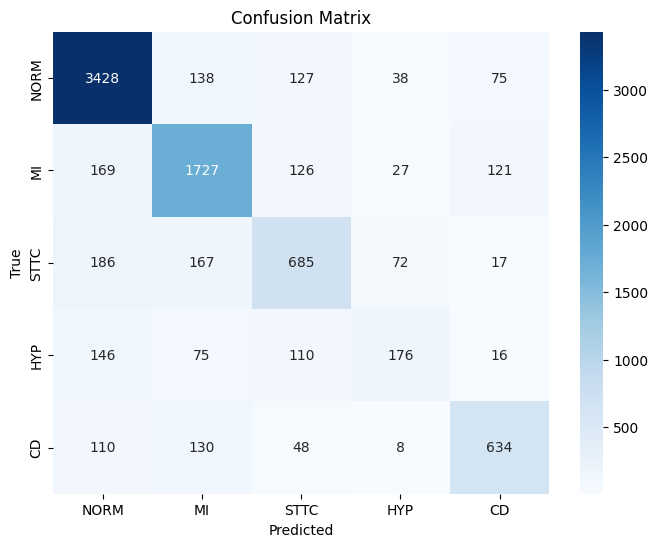

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1) Get predictions
# -----------------------------
y_pred = model.predict([X_time_val, X_fft_val])
y_pred = np.argmax(y_pred, axis=1)

# -----------------------------
# 2) Classification report
# -----------------------------
print(classification_report(y_val, y_pred))

# -----------------------------
# 3) Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORM','MI','STTC','HYP','CD'],
            yticklabels=['NORM','MI','STTC','HYP','CD'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# -----------------------------
# Inputs
# -----------------------------
inp_time = Input(shape=(1250, 12))
inp_fft  = Input(shape=(600, 12))

# -----------------------------
# Time-domain branch (CNN + BiLSTM)
# -----------------------------
x = Conv1D(64, 5, activation='relu', padding='same')(inp_time)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Attention
attention = Dense(1, activation='tanh')(x)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(256)(attention)
attention = Permute([2,1])(attention)

x = Multiply()([x, attention])
x = GlobalAveragePooling1D()(x)

# -----------------------------
# Frequency-domain branch (FFT CNN)
# -----------------------------
f = Conv1D(64, 5, activation='relu', padding='same')(inp_fft)
f = BatchNormalization()(f)
f = MaxPooling1D(2)(f)

f = Conv1D(128, 5, activation='relu', padding='same')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(2)(f)

f = GlobalAveragePooling1D()(f)

# -----------------------------
# Fusion
# -----------------------------
combined = Concatenate()([x, f])

combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.4)(combined)

combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)

out = Dense(5, activation='softmax')(combined)

model2 = Model(inputs=[inp_time, inp_fft], outputs=out)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1250, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 1250, 64)  │      3,904 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1250, 64)  │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 625, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 625, 128)  │     41,088 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 128)  │        512 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 312, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 312, 256)  │    263,168 │ max_pooling1d_11… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 600, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 312, 1)    │        257 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 600, 64)   │      3,904 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 312)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 600, 64)   │        256 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 312)       │          0 │ flatten_2[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 300, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 256, 312)  │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 300, 128)  │     41,088 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 312, 256)  │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 128)  │        512 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 487,046 (1.86 MB)

 Trainable params: 486,278 (1.86 MB)

 Non-trainable params: 768 (3.00 KB)

In [34]:
early = tf.keras.callbacks.EarlyStopping(
    patience=12,
    restore_best_weights=True
)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    patience=4,
    factor=0.3,
    min_lr=1e-7
)

history = model2.fit(
    [X_time_train, X_fft_train], y_train,
    validation_data=([X_time_val, X_fft_val], y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early, reduceLR]
)


Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.4681 - loss: 1.3853 - val_accuracy: 0.5926 - val_loss: 1.1562 - learning_rate: 1.0000e-04
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.5912 - loss: 1.1149 - val_accuracy: 0.6463 - val_loss: 0.9902 - learning_rate: 1.0000e-04
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.6387 - loss: 1.0147 - val_accuracy: 0.6657 - val_loss: 0.9349 - learning_rate: 1.0000e-04
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.6550 - loss: 0.9571 - val_accuracy: 0.6704 - val_loss: 0.9148 - learning_rate: 1.0000e-04
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.6654 - loss: 0.9342 - val_accuracy: 0.6732 - val_loss: 0.9002 - learning_rate: 1.0000e-04
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.6784 - loss: 0.9003 - val_accuracy: 0.6793 - val_loss: 0.8723 - learning_rate: 1.0000e-04
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━

Starting SOTA Training...
Train shape: (34220, 1250, 12) (34220, 600, 12)
Val shape: (8556, 1250, 12) (8556, 600, 12)
Class weights: {0: 0.4496124031007752, 1: 0.7886609817930399, 2: 1.5185267361881518, 3: 3.269947443860487, 4: 1.8397849462365592}


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1250, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 1250, 64)  │      6,976 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 625, 64)   │          0 │ conv1d_24[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 625, 64)   │     28,736 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 64)   │        256 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 625, 64)   │     28,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 64)   │        256 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 625, 64)   │          0 │ max_pooling1d_15… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 625, 64)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 625, 128)  │     57,472 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 128)  │        512 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 625, 128)  │    114,816 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 625, 128)  │      8,320 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 128)  │        512 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 625, 128)  │          0 │ conv1d_27[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 625, 128)  │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 625, 128)  │    114,816 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 128)  │        512 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 625, 128)  │    114,816 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 954,373 (3.64 MB)

 Trainable params: 952,581 (3.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4921 - loss: 1.3554
Epoch 1: val_loss improved from inf to 0.89107, saving model to best_sota_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 97s 159ms/step - accuracy: 0.4922 - loss: 1.3551 - val_accuracy: 0.6657 - val_loss: 0.8911 - learning_rate: 1.0000e-04
Epoch 2/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6493 - loss: 0.9845
Epoch 2: val_loss did not improve from 0.89107
535/535 ━━━━━━━━━━━━━━━━━━━━ 81s 152ms/step - accuracy: 0.6493 - loss: 0.9845 - val_accuracy: 0.6663 - val_loss: 0.8913 - learning_rate: 1.0000e-04
Epoch 3/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6906 - loss: 0.8818
Epoch 3: val_loss improved from 0.89107 to 0.80451, saving model to best_sota_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.6906 - loss: 0.8818 - val_accuracy: 0.6870 - val_loss: 0.8045 - learning_rate: 1.0000e-04
Epoch 4/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7138 - loss: 0.8224
Epoch 4: val_loss improved from 0.80451 to 0.70218, saving model to best_sota_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.7138 - loss: 0.8224 - val_accuracy: 0.7425 - val_loss: 0.7022 - learning_rate: 1.0000e-04
Epoch 5/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7226 - loss: 0.7580
Epoch 5: val_loss did not improve from 0.70218
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.7226 - loss: 0.7580 - val_accuracy: 0.6273 - val_loss: 0.9323 - learning_rate: 1.0000e-04
Epoch 6/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7378 - loss: 0.7081
Epoch 6: val_loss did not improve from 0.70218
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.7378 - loss: 0.7081 - val_accuracy: 0.6328 - val_loss: 0.9358 - learning_rate: 1.0000e-04
Epoch 7/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7530 - loss: 0.6537
Epoch 7: val_loss did not improve from 0.70218
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.7530 - loss: 0.6537 - val_accuracy: 0.7415 - val_loss: 0.7125 - learning_rate: 1.0000e-04


535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.7701 - loss: 0.5981 - val_accuracy: 0.7529 - val_loss: 0.6579 - learning_rate: 1.0000e-04
Epoch 9/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7938 - loss: 0.5363
Epoch 9: val_loss improved from 0.65793 to 0.58980, saving model to best_sota_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.7938 - loss: 0.5363 - val_accuracy: 0.7851 - val_loss: 0.5898 - learning_rate: 1.0000e-04
Epoch 10/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8102 - loss: 0.4823
Epoch 10: val_loss did not improve from 0.58980
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.8102 - loss: 0.4823 - val_accuracy: 0.7292 - val_loss: 0.7315 - learning_rate: 1.0000e-04
Epoch 11/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8201 - loss: 0.4332
Epoch 11: val_loss did not improve from 0.58980
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.8201 - loss: 0.4332 - val_accuracy: 0.7937 - val_loss: 0.6018 - learning_rate: 1.0000e-04
Epoch 12/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8449 - loss: 0.3720
Epoch 12: val_loss did not improve from 0.58980
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.8449 - loss: 0.3721 - val_accuracy: 0.7763 - val_loss: 0.6416 - learning_rate: 1.000

535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.8999 - loss: 0.2091 - val_accuracy: 0.8463 - val_loss: 0.4818 - learning_rate: 3.0000e-05
Epoch 16/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9373 - loss: 0.1267
Epoch 16: val_loss did not improve from 0.48179
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9373 - loss: 0.1267 - val_accuracy: 0.8581 - val_loss: 0.4963 - learning_rate: 3.0000e-05
Epoch 17/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9455 - loss: 0.1074
Epoch 17: val_loss did not improve from 0.48179
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9455 - loss: 0.1074 - val_accuracy: 0.8541 - val_loss: 0.5204 - learning_rate: 3.0000e-05
Epoch 18/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9518 - loss: 0.0919
Epoch 18: val_loss did not improve from 0.48179
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9518 - loss: 0.0919 - val_accuracy: 0.8507 - val_loss: 0.5779 - learning_rate: 3.000

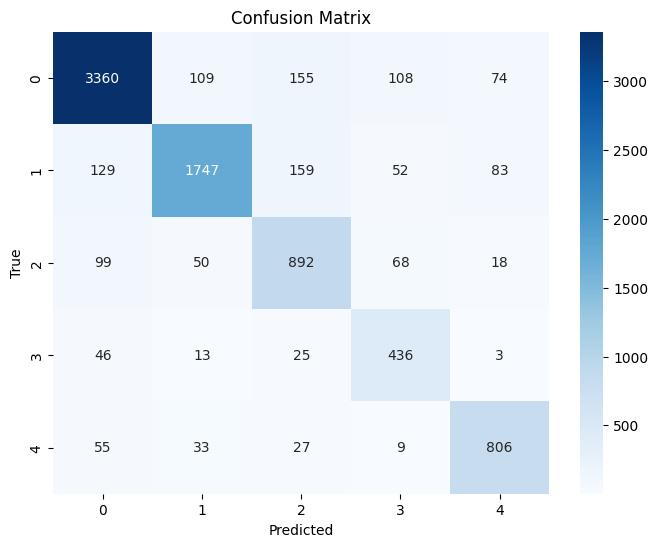


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3806
           1       0.89      0.81      0.85      2170
           2       0.71      0.79      0.75      1127
           3       0.65      0.83      0.73       523
           4       0.82      0.87      0.84       930

    accuracy                           0.85      8556
   macro avg       0.80      0.84      0.81      8556
weighted avg       0.85      0.85      0.85      8556



In [36]:
print("Starting SOTA Training...")

# -------------------------------------------------------------
# 1) TRAIN-TEST SPLIT
# -------------------------------------------------------------
from sklearn.model_selection import train_test_split
X_time_train, X_time_val, X_fft_train, X_fft_val, y_train, y_val = train_test_split(
    X_time, X_fft, Y, test_size=0.2, random_state=42, stratify=Y
)

print("Train shape:", X_time_train.shape, X_fft_train.shape)
print("Val shape:", X_time_val.shape, X_fft_val.shape)

# -------------------------------------------------------------
# 2) CLASS WEIGHTS (for imbalance improvement)
# -------------------------------------------------------------
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: cw[i] for i in range(len(cw))}
print("Class weights:", class_weights)

# -------------------------------------------------------------
# 3) MODEL ARCHITECTURE
# -------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# ---------------- Residual Block ----------------
def residual_block(x, filters, kernel_size=7):
    shortcut = x

    # Match channel dimensions if needed
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    # Main path
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add skip connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# ---------------- Attention Block ----------------
def attention_block(inputs):
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attn_output = Dropout(0.2)(attn_output)
    out = LayerNormalization()(inputs + attn_output)
    return out

# ---------------- TIME DOMAIN BRANCH ----------------
inp_time = Input(shape=(1250, 12))

t = Conv1D(64, 9, activation='relu', padding='same')(inp_time)
t = MaxPooling1D(2)(t)

# 3 Residual blocks
for f in [64, 128, 128]:
    t = residual_block(t, f)

t = MaxPooling1D(2)(t)
t = Bidirectional(LSTM(64, return_sequences=True))(t)
t = attention_block(t)
t = GlobalAveragePooling1D()(t)

# ---------------- FFT DOMAIN BRANCH ----------------
inp_fft = Input(shape=(600, 12))

f = Conv1D(64, 7, activation='relu', padding='same')(inp_fft)
f = MaxPooling1D(2)(f)

f = Conv1D(128, 5, activation='relu', padding='same')(f)
f = MaxPooling1D(2)(f)

f = Bidirectional(LSTM(64, return_sequences=True))(f)
f = attention_block(f)
f = GlobalAveragePooling1D()(f)

# ---------------- FUSION ----------------
combined = Concatenate()([t, f])
combined = BatchNormalization()(combined)
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.3)(combined)
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)

output = Dense(5, activation='softmax')(combined)

model = Model(inputs=[inp_time, inp_fft], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -------------------------------------------------------------
# 4) TRAINING CALLBACKS
# -------------------------------------------------------------
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_sota_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
    mode="min"
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    factor=0.3,
    verbose=1
)

# -------------------------------------------------------------
# 5) MODEL TRAINING
# -------------------------------------------------------------
history = model.fit(
    [X_time_train, X_fft_train],
    y_train,
    validation_data=([X_time_val, X_fft_val], y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduceLR],
    verbose=1
)

print("Training Completed.")

# -------------------------------------------------------------
# 6) CONFUSION MATRIX
# -------------------------------------------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

preds = model.predict([X_time_val, X_fft_val])
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, preds))


Using shapes:
Train: (34220, 1250, 12) (34220, 600, 12)
Val: (8556, 1250, 12) (8556, 600, 12)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1250, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 1250, 64)  │        832 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1250, 64)  │        256 │ conv1d_106[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 1250, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 1250, 64)  │     36,928 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 1250, 64)  │     77,888 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 1250, 64)  │    159,808 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 1250, 192) │          0 │ conv1d_108[0][0], │
│ (Concatenate)       │                   │            │ conv1d_109[0][0], │
│                     │                   │            │ conv1d_110[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1250, 192) │        768 │ concatenate_25[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 1250, 64)  │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 1250, 64)  │    233,536 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 1250, 64)  │    479,296 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 1250, 192) │          0 │ conv1d_111[0][0], │
│ (Concatenate)       │                   │            │ conv1d_112[0][0], │
│                     │                   │            │ conv1d_113[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1250, 192) │        768 │ concatenate_26[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 1250, 192) │     12,480 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1250, 192) │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_107[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 1250, 192) │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 625, 192)  │          0 │ activation_18[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_115 (Conv1D) │ (None, 625, 96)   │    165,984 │ max_pooling1d_34

 Total params: 10,876,197 (41.49 MB)

 Trainable params: 10,871,589 (41.47 MB)

 Non-trainable params: 4,608 (18.00 KB)

Starting InceptionTime Training...
Epoch 1/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.5231 - loss: 1.3238
Epoch 1: val_loss improved from inf to 0.95329, saving model to best_inception_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 357s 619ms/step - accuracy: 0.5232 - loss: 1.3235 - val_accuracy: 0.6282 - val_loss: 0.9533 - learning_rate: 1.0000e-04
Epoch 2/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6569 - loss: 0.9751
Epoch 2: val_loss improved from 0.95329 to 0.79862, saving model to best_inception_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 313s 585ms/step - accuracy: 0.6569 - loss: 0.9751 - val_accuracy: 0.6981 - val_loss: 0.7986 - learning_rate: 1.0000e-04
Epoch 3/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6803 - loss: 0.8870
Epoch 3: val_loss improved from 0.79862 to 0.75788, saving model to best_inception_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 312s 582ms/step - accuracy: 0.6803 - loss: 0.8870 - val_accuracy: 0.7328 - val_loss: 0.7579 - learning_rate: 1.0000e-04
Epoch 4/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7048 - loss: 0.8187
Epoch 4: val_loss improved from 0.75788 to 0.65879, saving model to best_inception_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 312s 583ms/step - accuracy: 0.7048 - loss: 0.8187 - val_accuracy: 0.7516 - val_loss: 0.6588 - learning_rate: 1.0000e-04
Epoch 5/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7245 - loss: 0.7657
Epoch 5: val_loss did not improve from 0.65879
535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 581ms/step - accuracy: 0.7245 - loss: 0.7657 - val_accuracy: 0.6637 - val_loss: 0.8732 - learning_rate: 1.0000e-04
Epoch 6/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7352 - loss: 0.7195
Epoch 6: val_loss did not improve from 0.65879
535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 581ms/step - accuracy: 0.7352 - loss: 0.7195 - val_accuracy: 0.7534 - val_loss: 0.6659 - learning_rate: 1.0000e-04
Epoch 7/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7479 - loss: 0.6546
Epoch 7: val_loss did not improve from 0.65879
535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 581ms/step - accuracy: 0.7479 - loss: 0.6546 - val_accuracy: 0.7180 - val_loss: 0.7356 - learning_rate: 1.0000e-04

535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 582ms/step - accuracy: 0.8536 - loss: 0.3493 - val_accuracy: 0.8337 - val_loss: 0.4883 - learning_rate: 3.0000e-05
Epoch 11/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9058 - loss: 0.2117
Epoch 11: val_loss improved from 0.48835 to 0.47749, saving model to best_inception_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 581ms/step - accuracy: 0.9058 - loss: 0.2117 - val_accuracy: 0.8478 - val_loss: 0.4775 - learning_rate: 3.0000e-05
Epoch 12/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9268 - loss: 0.1540
Epoch 12: val_loss improved from 0.47749 to 0.45370, saving model to best_inception_model.h5


535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 580ms/step - accuracy: 0.9268 - loss: 0.1540 - val_accuracy: 0.8652 - val_loss: 0.4537 - learning_rate: 3.0000e-05
Epoch 13/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9436 - loss: 0.1211
Epoch 13: val_loss did not improve from 0.45370
535/535 ━━━━━━━━━━━━━━━━━━━━ 310s 580ms/step - accuracy: 0.9436 - loss: 0.1211 - val_accuracy: 0.8566 - val_loss: 0.5008 - learning_rate: 3.0000e-05
Epoch 14/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9554 - loss: 0.0922
Epoch 14: val_loss did not improve from 0.45370
535/535 ━━━━━━━━━━━━━━━━━━━━ 310s 579ms/step - accuracy: 0.9554 - loss: 0.0922 - val_accuracy: 0.8795 - val_loss: 0.4557 - learning_rate: 3.0000e-05
Epoch 15/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9664 - loss: 0.0703
Epoch 15: val_loss did not improve from 0.45370
535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 581ms/step - accuracy: 0.9664 - loss: 0.0703 - val_accuracy: 0.8665 - val_loss: 0.5414 - learning_rate: 3.00

535/535 ━━━━━━━━━━━━━━━━━━━━ 311s 581ms/step - accuracy: 0.9879 - loss: 0.0289 - val_accuracy: 0.9198 - val_loss: 0.4117 - learning_rate: 9.0000e-06
Epoch 19/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9945 - loss: 0.0135
Epoch 19: val_loss did not improve from 0.41166
535/535 ━━━━━━━━━━━━━━━━━━━━ 310s 579ms/step - accuracy: 0.9945 - loss: 0.0135 - val_accuracy: 0.9226 - val_loss: 0.4280 - learning_rate: 9.0000e-06
Epoch 20/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9946 - loss: 0.0107
Epoch 20: val_loss did not improve from 0.41166
535/535 ━━━━━━━━━━━━━━━━━━━━ 310s 579ms/step - accuracy: 0.9946 - loss: 0.0107 - val_accuracy: 0.9261 - val_loss: 0.4396 - learning_rate: 9.0000e-06
Epoch 21/30
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9967 - loss: 0.0082
Epoch 21: val_loss did not improve from 0.41166
535/535 ━━━━━━━━━━━━━━━━━━━━ 310s 580ms/step - accuracy: 0.9967 - loss: 0.0082 - val_accuracy: 0.9266 - val_loss: 0.4598 - learning_rate: 9.00

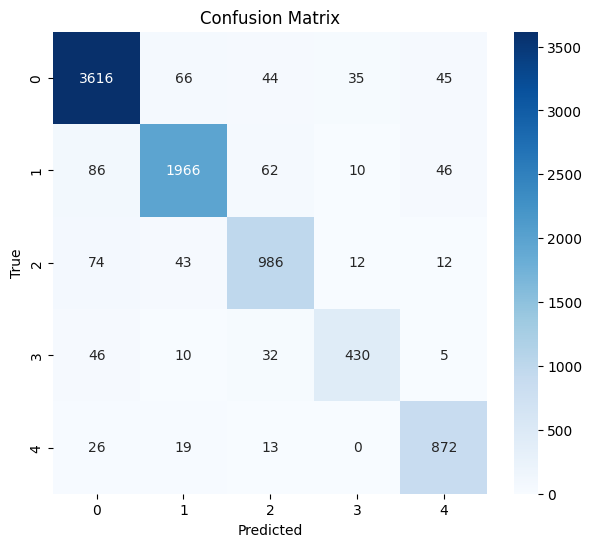

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import numpy as np

print("Using shapes:")
print("Train:", X_time_train.shape, X_fft_train.shape)
print("Val:", X_time_val.shape, X_fft_val.shape)

# ====================================================================================
# 1. INCEPTIONTIME BLOCK
# ====================================================================================

def inception_module(x, nb_filters):
    # 3 parallel conv paths
    conv1 = Conv1D(nb_filters, 9, padding='same', activation='relu')(x)
    conv2 = Conv1D(nb_filters, 19, padding='same', activation='relu')(x)
    conv3 = Conv1D(nb_filters, 39, padding='same', activation='relu')(x)

    x = Concatenate()([conv1, conv2, conv3])
    x = BatchNormalization()(x)
    return x


def residual_inception_block(x, filters):
    shortcut = Conv1D(filters * 3, 1, padding='same')(x)

    x = inception_module(x, filters)
    x = inception_module(x, filters)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


# ====================================================================================
# 2. TIME DOMAIN BRANCH  (InceptionTime)
# ====================================================================================

input_time = Input(shape=(1250, 12))

t = Conv1D(64, 1, padding='same')(input_time)
t = BatchNormalization()(t)
t = Activation('relu')(t)

# 3 residual inception blocks
for f in [64, 96, 128]:
    t = residual_inception_block(t, f)
    t = MaxPooling1D(2)(t)

# Attention
t = MultiHeadAttention(num_heads=4, key_dim=64)(t, t)
t = LayerNormalization()(t)
t = GlobalAveragePooling1D()(t)

# ====================================================================================
# 3. FFT BRANCH (simpler CNN + attention)
# ====================================================================================

input_fft = Input(shape=(600, 12))

f = Conv1D(64, 5, padding='same', activation='relu')(input_fft)
f = MaxPooling1D(2)(f)
f = Conv1D(128, 5, padding='same', activation='relu')(f)
f = MaxPooling1D(2)(f)

f = MultiHeadAttention(num_heads=4, key_dim=64)(f, f)
f = LayerNormalization()(f)
f = GlobalAveragePooling1D()(f)

# ====================================================================================
# 4. FUSION
# ====================================================================================

combined = Concatenate()([t, f])
combined = BatchNormalization()(combined)

combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.4)(combined)
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)

output = Dense(5, activation='softmax')(combined)

# ====================================================================================
# 5. BUILD MODEL
# ====================================================================================

model = Model([input_time, input_fft], output)
model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ====================================================================================
# 6. CALLBACKS
# ====================================================================================

callbacks = [
    ModelCheckpoint("best_inception_model.h5", save_best_only=True, monitor="val_loss", verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, verbose=1),
    EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1)
]

# ====================================================================================
# 7. TRAIN
# ====================================================================================

print("Starting InceptionTime Training...")

history = model.fit(
    [X_time_train, X_fft_train],
    y_train,
    validation_data=([X_time_val, X_fft_val], y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

# ============================================================
# 8) FINAL EVALUATION (AUTO-RUN AFTER TRAINING)
# ============================================================

print("\nEvaluating model...")

# Predict
y_pred = np.argmax(model.predict([X_time_val, X_fft_val]), axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


